In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [3]:
num_epochs = 25
percentage_of_train_dataset = 0.20 #Out of 60K Image (To Speed up Training)
percentage_of_test_dataset = 0.20 # Out of 10K Images (To Speed up Testing)


loss_history =[]
acc_history =[]
min_loss = 9999 #To implement Simple Early Stopping
no_improvement_epoch = 0 #To implement Simple Early Stopping


https://github.com/deepinsight/insightface/blob/master/recognition/arcface_torch/losses.py

In [4]:
class ArcLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, scale=2.0, margin=3.0):
        super(ArcLoss, self).__init__()

        
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.scale = scale
        self.margin = margin
        self.threshold = torch.cos(torch.tensor(np.pi - margin))
        margin = torch.Tensor([margin])
        self.cos_m = torch.cos(margin)
        self.sin_m = torch.sin(margin)
 
      

    def forward(self, inputs, labels):
        # Normalize feature vectors
        logits = F.normalize(inputs, p=2, dim=1)
        
        # Compute arc cosine
        arc = torch.acos(torch.clamp(logits, -1.0 + torch.finfo(torch.float32).eps, 1.0 - torch.finfo(torch.float32).eps))

        # Compute arcface loss
        target_cos = torch.cos(arc + self.margin)
        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, labels.view(-1, 1), 1)
        output = one_hot * target_cos + (1.0 - one_hot) * logits
        output *= self.scale
        loss = F.cross_entropy(inputs, labels).mean()

        return loss

In [5]:
# Data Augmentation and Normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [6]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.CIFAR10(root='./cifar_data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./cifar_data', train=False, transform=transform_test, download=True)

indices = np.arange(len(train_dataset))
indices2 = np.arange(len(test_dataset))

train_indices, _ = train_test_split(indices, train_size=percentage_of_train_dataset, stratify=train_dataset.targets)
test_indices, _ = train_test_split(indices2, train_size=percentage_of_test_dataset, stratify=test_dataset.targets)

# Warp into Subsets and DataLoaders
train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:

# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = x.view(-1, 128 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [8]:
model = Net()
model.to(device)

# Define ArcLoss criterion and optimizer
criterion = ArcLoss(num_classes=10, embedding_size=512)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [9]:

# Training loop
for epoch in range(num_epochs):

    model.train()
    avg_loss = 0
    loop_count = 0

    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(images.to(device))
        loss = criterion(output, labels.to(device))
        # print("op:", output, type(output), output.shape)
        # print("lb:", labels, type(labels), labels.shape)
        loss.backward()
        optimizer.step()
        
        loop_count +=1
        avg_loss += loss.tolist()

    avg_loss /= loop_count
    print("Avg Loss:", avg_loss)

    loss_history.append(avg_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            output = model(images.to(device))
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            # print(predicted.shape, labels.shape)
            correct += (predicted == labels.to(device)).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

    acc_history.append(accuracy)


    if avg_loss < min_loss:
        min_loss = avg_loss
        # print("Model Improved")
        no_improvement_epoch = 0
    else:
        # print("No Improvement")
        no_improvement_epoch += 1
    
    if no_improvement_epoch > 10:
        print("Early Stopping, No Improvement since few Epochs")
        break


print('Training Finished')

100%|██████████| 79/79 [00:07<00:00, 10.73it/s]


Avg Loss: 1.8909753802456433


100%|██████████| 16/16 [00:00<00:00, 38.25it/s]


Epoch [1/25], Test Accuracy: 35.00%


100%|██████████| 79/79 [00:04<00:00, 16.11it/s]


Avg Loss: 1.6095174505740781


100%|██████████| 16/16 [00:00<00:00, 37.80it/s]


Epoch [2/25], Test Accuracy: 45.95%


100%|██████████| 79/79 [00:04<00:00, 15.96it/s]


Avg Loss: 1.485519822639755


100%|██████████| 16/16 [00:00<00:00, 36.61it/s]


Epoch [3/25], Test Accuracy: 50.60%


100%|██████████| 79/79 [00:05<00:00, 15.72it/s]


Avg Loss: 1.3688337848156313


100%|██████████| 16/16 [00:00<00:00, 37.17it/s]


Epoch [4/25], Test Accuracy: 53.25%


100%|██████████| 79/79 [00:05<00:00, 15.69it/s]


Avg Loss: 1.2731192730650116


100%|██████████| 16/16 [00:00<00:00, 37.69it/s]


Epoch [5/25], Test Accuracy: 58.50%


100%|██████████| 79/79 [00:05<00:00, 15.40it/s]


Avg Loss: 1.219846283333211


100%|██████████| 16/16 [00:00<00:00, 33.37it/s]


Epoch [6/25], Test Accuracy: 57.75%


100%|██████████| 79/79 [00:04<00:00, 15.93it/s]


Avg Loss: 1.1550524604471424


100%|██████████| 16/16 [00:00<00:00, 38.06it/s]


Epoch [7/25], Test Accuracy: 61.55%


100%|██████████| 79/79 [00:05<00:00, 15.49it/s]


Avg Loss: 1.0954365549208243


100%|██████████| 16/16 [00:00<00:00, 38.19it/s]


Epoch [8/25], Test Accuracy: 58.05%


100%|██████████| 79/79 [00:05<00:00, 15.80it/s]


Avg Loss: 1.0655440295798868


100%|██████████| 16/16 [00:00<00:00, 38.05it/s]


Epoch [9/25], Test Accuracy: 59.00%


100%|██████████| 79/79 [00:05<00:00, 15.28it/s]


Avg Loss: 1.0460658435580097


100%|██████████| 16/16 [00:00<00:00, 35.44it/s]


Epoch [10/25], Test Accuracy: 66.20%


100%|██████████| 79/79 [00:05<00:00, 15.80it/s]


Avg Loss: 1.0092031948174103


100%|██████████| 16/16 [00:00<00:00, 38.52it/s]


Epoch [11/25], Test Accuracy: 66.50%


100%|██████████| 79/79 [00:04<00:00, 16.06it/s]


Avg Loss: 0.9443829270857799


100%|██████████| 16/16 [00:00<00:00, 37.30it/s]


Epoch [12/25], Test Accuracy: 66.95%


100%|██████████| 79/79 [00:05<00:00, 15.48it/s]


Avg Loss: 0.9139471770841864


100%|██████████| 16/16 [00:00<00:00, 36.66it/s]


Epoch [13/25], Test Accuracy: 69.35%


100%|██████████| 79/79 [00:05<00:00, 15.47it/s]


Avg Loss: 0.8812558462348166


100%|██████████| 16/16 [00:00<00:00, 35.93it/s]


Epoch [14/25], Test Accuracy: 67.35%


100%|██████████| 79/79 [00:05<00:00, 15.48it/s]


Avg Loss: 0.875827332086201


100%|██████████| 16/16 [00:00<00:00, 37.54it/s]


Epoch [15/25], Test Accuracy: 69.55%


100%|██████████| 79/79 [00:04<00:00, 16.08it/s]


Avg Loss: 0.8468398338631739


100%|██████████| 16/16 [00:00<00:00, 37.33it/s]


Epoch [16/25], Test Accuracy: 70.40%


100%|██████████| 79/79 [00:04<00:00, 16.32it/s]


Avg Loss: 0.8202702901031398


100%|██████████| 16/16 [00:00<00:00, 37.66it/s]


Epoch [17/25], Test Accuracy: 72.05%


100%|██████████| 79/79 [00:04<00:00, 16.06it/s]


Avg Loss: 0.7804851690425149


100%|██████████| 16/16 [00:00<00:00, 37.01it/s]


Epoch [18/25], Test Accuracy: 69.70%


100%|██████████| 79/79 [00:05<00:00, 15.54it/s]


Avg Loss: 0.7621436854706535


100%|██████████| 16/16 [00:00<00:00, 36.96it/s]


Epoch [19/25], Test Accuracy: 69.05%


100%|██████████| 79/79 [00:05<00:00, 15.66it/s]


Avg Loss: 0.7307859915721265


100%|██████████| 16/16 [00:00<00:00, 36.92it/s]


Epoch [20/25], Test Accuracy: 69.20%


100%|██████████| 79/79 [00:05<00:00, 15.62it/s]


Avg Loss: 0.713967943493324


100%|██████████| 16/16 [00:00<00:00, 35.27it/s]


Epoch [21/25], Test Accuracy: 66.65%


100%|██████████| 79/79 [00:05<00:00, 15.66it/s]


Avg Loss: 0.7078795946097072


100%|██████████| 16/16 [00:00<00:00, 36.68it/s]


Epoch [22/25], Test Accuracy: 74.20%


100%|██████████| 79/79 [00:05<00:00, 15.53it/s]


Avg Loss: 0.6680505185187617


100%|██████████| 16/16 [00:00<00:00, 37.51it/s]


Epoch [23/25], Test Accuracy: 72.00%


100%|██████████| 79/79 [00:04<00:00, 16.16it/s]


Avg Loss: 0.6590379518044146


100%|██████████| 16/16 [00:00<00:00, 35.76it/s]


Epoch [24/25], Test Accuracy: 73.90%


100%|██████████| 79/79 [00:05<00:00, 15.71it/s]


Avg Loss: 0.6777194610124901


100%|██████████| 16/16 [00:00<00:00, 37.04it/s]

Epoch [25/25], Test Accuracy: 72.65%
Training Finished


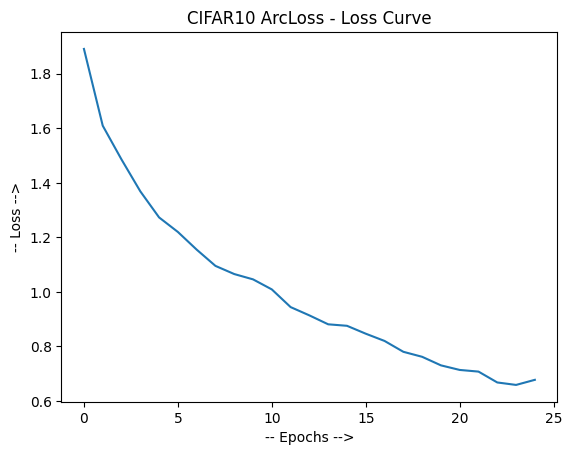

In [10]:
plt.plot(loss_history)
plt.title("CIFAR10 ArcLoss - Loss Curve")
plt.xlabel("-- Epochs -->")
plt.ylabel("-- Loss -->")
plt.savefig("arcloss_cifar10_loss.png")
plt.show()

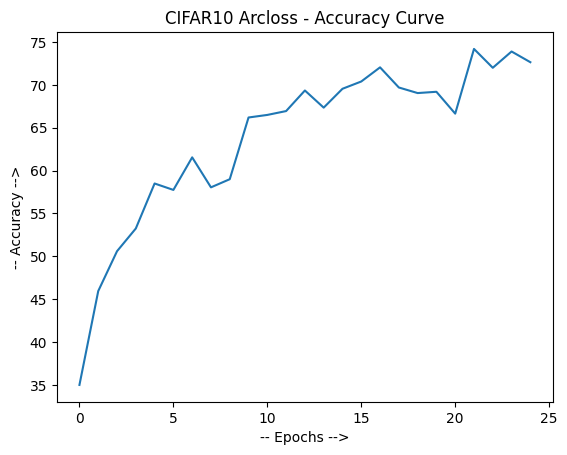

In [11]:
plt.plot(acc_history)
plt.title("CIFAR10 Arcloss - Accuracy Curve")
plt.xlabel("-- Epochs -->")
plt.ylabel("-- Accuracy -->")
plt.savefig("arcloss_cifar10_accuracy.png")
plt.show()

In [12]:
# Model accuracy testing
model.eval()
correct = 0
total = 0
optimizer.zero_grad()
with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing"):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the CIFAR10 test set: {(100 * correct / total):.2f}%")

Testing: 100%|██████████| 16/16 [00:00<00:00, 34.72it/s]

Accuracy on the CIFAR10 test set: 72.65%


In [13]:
# Test the Model

all_labels = []
all_predicted = []

with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        labels = labels.to(device)
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        
        for lbl in labels.tolist():
            all_labels.append(lbl)

        for pred in predicted.tolist():
            all_predicted.append(pred)

accuracy = metrics.accuracy_score(all_labels, all_predicted)
precision = metrics.precision_score(all_labels, all_predicted, average="weighted")
print("Accuracy:", accuracy)
print("Precision:", precision)

100%|██████████| 16/16 [00:00<00:00, 33.14it/s]

Accuracy: 0.7265
Precision: 0.7374340528520245


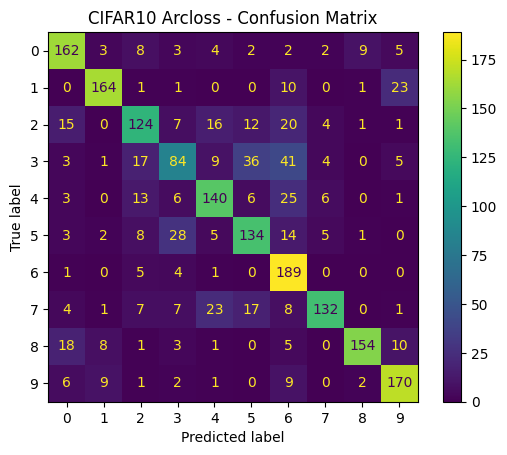

In [14]:
confusion_matrix = metrics.confusion_matrix(all_labels, all_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.title("CIFAR10 Arcloss - Confusion Matrix")
plt.savefig("arcloss_cifar10_cm.png")
plt.show()